# Textual Phenomena

This notebook deals with typical structures examined in natural language processing, including preprocessing (tokenisation, part-of-speech tagging), morpholigical analysis (lemmatisation), morphosyntactic analysis (dependency parsing, sentence splitting, clause/tense/mood/voice/modality tagging), semantic analysis (named entity regognition and entity linking, emotion analysis, tagging of temponyms and verb/adjective categories), speech and speaker analysis and coreference analysis.
Higher level narrative structures such as literary events or reflective passages are examined in notebook 3.

The code package MONAPipe provides new pipeline components for spaCy. This notebook also shows how to use them.

## Imports
At first, import the components from MONAPipe that you want to use:

In [1]:
import monapipe.model
import monapipe.pipeline.clausizer.dependency_clausizer
import monapipe.pipeline.coref.rb_coref
import monapipe.pipeline.speech_tagger.flair_speech_tagger
import monapipe.pipeline.speech_tagger.quotation_marks_speech_tagger
import monapipe.pipeline.temponym_tagger.heideltime_temponym_tagger
import monapipe.pipeline.verb_analyzer.rb_verb_analyzer
import monapipe.resource_handler as resources

/home/fbarth/GIT/mona-pipe/env_dev/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For this notebook, you need to further import classes from the `tgclients` library to load texts from the Textgrid Repository.

In [2]:
# import TextGrid components
from tgclients.aggregator import Aggregator
aggregator = Aggregator()

## Loading the pipeline 

In the next step you will build your first pipeline: The pipeline is initialized via the `monapipe.model.load()`-method and stored in the variable `nlp`. (Here, the non-default languge model for German that comes with MONAPipe is loaded.) Each pipeline already has the components `tok2vec` (embedding encoder), `tagger` (part-of-speach tagger), `morphologizer` (morphological analyzer), `trainable_lemmatizer` (Lemmatizer), `parser` (dependency parser), `ner` (named entity recognizer) right from the start.

With the `add_pipe` method, you can add further components. In general, it is important to define the pipeline in the correct order.

In [3]:
# create pipeline object
nlp = monapipe.model.load()
# add components
nlp.add_pipe("dependency_clausizer")

In [4]:
# show components currently part of the pipeline
print(nlp.pipe_names)

['tok2vec', 'tagger', 'morphologizer', 'trainable_lemmatizer', 'parser', 'ner', 'dependency_clausizer']


## Loading a text

To find a text in the TextGrid repository, you can use the search interface here: https://textgridrep.org.
Each text in the TextGrid repository has a unique identifier (TextGrid URI) that you need to load the text via the `tgclients` library from TextGrid. For example, if you search for `Fontane Stechlin` in the interface, you find Theodor Fontane's *Der Stechlin* as second hit. When clicking on it, the URL of the website switches to the following:  `https://textgridrep.de/browse/n143.0`. Here, the string after the last slash (`n143.0`) is the TextGrid URI.
In the next step, you can use the URI in conjunction with the namespace `textgrid` to load Fontane's novel as plain text.

In [5]:
# Load the text from TextGrid repository:
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text

In [6]:
# The variable `text_fontane_stechlin` contains the complete text as plain text.
# You can print a sclice of it to inspect the content:
print(text_fontane_stechlin[0:485])

Theodor Fontane
Der Stechlin
Roman
Schloß Stechlin
1. Kapitel
Erstes Kapitel
Im Norden der Grafschaft Ruppin, hart an der mecklenburgischen Grenze, zieht sich von dem Städtchen Gransee bis nach Rheinsberg hin (und noch darüber hinaus) eine mehrere Meilen lange Seenkette durch eine menschenarme, nur hie und da mit ein paar alten Dörfern, sonst aber ausschließlich mit Förstereien, Glas- und Teeröfen besetzte Waldung. Einer der Seen, die diese Seenkette bilden, heißt »der
Stechlin
«.


To run the pipeline defined above, you have to call it from the `nlp`-variable, where the pipeline definition is stored in an object. You pass the text to the object, which creates the so called `doc` object – this is one of the main objects of spaCy.

In [7]:
# Pipe text through the pipeline:
doc_fontane_stechlin = nlp(text_fontane_stechlin[76:9500])

In [8]:
# Print first tokens of doc object:
print(doc_fontane_stechlin[0:300])


Im Norden der Grafschaft Ruppin, hart an der mecklenburgischen Grenze, zieht sich von dem Städtchen Gransee bis nach Rheinsberg hin (und noch darüber hinaus) eine mehrere Meilen lange Seenkette durch eine menschenarme, nur hie und da mit ein paar alten Dörfern, sonst aber ausschließlich mit Förstereien, Glas- und Teeröfen besetzte Waldung. Einer der Seen, die diese Seenkette bilden, heißt »der
Stechlin
«. Zwischen flachen, nur an einer einzigen Stelle steil und quaiartig ansteigenden Ufern liegt er da, rundum von alten Buchen eingefaßt, deren Zweige, von ihrer eignen Schwere nach unten gezogen, den See mit ihrer Spitze berühren. Hie und da wächst ein weniges von Schilf und Binsen auf, aber kein Kahn zieht seine Furchen, kein Vogel singt, und nur selten, daß ein Habicht drüber hinfliegt und seinen Schatten auf die Spiegelfläche wirft. Alles still hier. Und doch, von Zeit zu Zeit wird es an eben dieser Stelle lebendig. Das ist, wenn es weit draußen in der Welt, sei's auf Island, sei's a

## Levels for textual phenomena

Textual phenomena can cover longer spans of text or shorter snippets with only one or a few tokens. Accordingly, they are either attributed to a `Doc`, `Token` or `Span` object:

- `Doc`-level phenomena apply to the entire document. One could, for example, store meta data about a text at the `Doc`-level. You can find another example in notebook 4.
- `Token`-level phenomena apply to single words. Examples include part of speech, lemma or syntactic dependency relation.
- `Span`-level phenomena are very flexible, since spans can be anything from a few words to large text segments. Certain pipeline components define specific spans which can then, after their definition, receive attributes. Notebook 1 has already shown that sentences are spans. Other examples are:
    - The `ner` component (spaCy) defines named entities, which typically span not more than a few words.
    - The `clausizer` component (MONAPipe) defines clauses, which are linguistic units within a sentence.

Specific examples are shown in the following.

### Token-Level

#### Part-of-Speech tags

Each word or token has a part of speech (POS), which is the grammatical category (e.g. noun, verb, adjective) of the word. SpaCy's `tagger` component assigns POS tags to each token. To get the POS of a token, you need to add `.pos_` to the token.

Here is the list of part-of-speech abbreviations used in spaCy:

**ADJ** adjective <br>
**ADP** adposition <br>
**ADV** adverb <br>
**AUX** auxiliary <br>
**CCONJ** coordinating conjunction <br>
**DET** determiner <br>
**INTJ** interjection <br>
**NOUN** noun <br>
**NUM** numeral <br>
**PART** particle <br>
**PRON** pronoun <br>
**PROPN** proper noun <br>
**PUNCT** punctuation <br>
**SCONJ** subordinating conjunction <br>
**SPACE** empty space <br>
**SYM** symbol <br>
**VERB** verb <br>
**X** other <br>

In [9]:
for token in doc_fontane_stechlin[1:60]:
    print(token, token.pos_)

Im ADP
Norden NOUN
der DET
Grafschaft NOUN
Ruppin PROPN
, PUNCT
hart ADJ
an ADP
der DET
mecklenburgischen ADJ
Grenze NOUN
, PUNCT
zieht VERB
sich PRON
von ADP
dem DET
Städtchen NOUN
Gransee PROPN
bis ADP
nach ADP
Rheinsberg PROPN
hin ADV
( PUNCT
und CCONJ
noch ADV
darüber ADV
hinaus ADV
) PUNCT
eine DET
mehrere PRON
Meilen NOUN
lange ADJ
Seenkette NOUN
durch ADP
eine DET
menschenarme ADJ
, PUNCT
nur ADV
hie ADV
und CCONJ
da ADV
mit ADP
ein DET
paar PRON
alten ADJ
Dörfern NOUN
, PUNCT
sonst ADV
aber ADV
ausschließlich ADV
mit ADP
Förstereien NOUN
, PUNCT
Glas- NOUN
und CCONJ
Teeröfen NOUN
besetzte ADJ
Waldung NOUN
. PUNCT


### Span-Level

#### Named entites

Named Entity Regognition (NER) is one of the important classification tasks in semantic analysis. The term "named entity" simply means anything that can be referred to with a proper name.
In the next cell, the named entites categorized as persons (PER) respectively locations (LOC) occuring in the current document are printed (note that the named-entity type is an attribute of each token within the entity and not of the entity span).

You can get the entity type of a named entity by appending `.ent_type_` to any token of the named entity.

In [10]:
# create pipeline object
nlp = monapipe.model.load(disable=['tok2vec', 'tagger', 'morphologizer', 'trainable_lemmatizer', 'parser'])
print(nlp.pipe_names)

['ner']


In [11]:
# Load the text from TextGrid repository:
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text
# Pipe text through the pipeline:
doc_fontane_stechlin = nlp(text_fontane_stechlin[76:9500])

In [12]:
# LOC (location) entities
for ent in doc_fontane_stechlin.ents:
    if ent[0].ent_type_ == "LOC":
        print(ent)

Grafschaft Ruppin
mecklenburgischen Grenze
Gransee
Rheinsberg
Stechlin
Hie
Island
Java
Südsee hinausgetrieben
Stechlin
Lissabon
strudelt
Stechlin
See
Stechlin
Stechlin
Kloster Wutz
Kastanienallee
Dorf Stechlin
Schwefelfäden
lehnan
Holzarm
Kloster Wutz
Kastanienallee
Bohlenbrücke
Stechlin
Schloß
Stechlin
Schloßgraben
Aloeblätter
Stechlin
Sechzig
Märkischen
Schleswig
Märkischen
Brandenburg
Insel Usedom
Märkischer
Friesack


In [13]:
for ent in doc_fontane_stechlin.ents:
    if ent[0].ent_type_ == "PER":
        print(ent)

Kahn
Krug
Friedrich Wilhelms I.
Dubslav von Stechlin
Paradoxen
Friedrich Wilhelms IV.
Anno vierundsechzig
Sohn
Vaters
Dubslav
Dubslav
Joachim
Woldemar
Raoul
Dubslav von Stechlin
schw


#### Named Entities - Hands-on

As seen above, the Named Entity Recognition gives out all occurences of named entities in a given text. As a consequence, names that occur several times in the text occur as many times in the list as well (e.g. 'Dubslav'). 

In the following exercise, you have to compare two fictional texts regarding the variety of characters occuring in them. In the following cell, the snippets of Kafka's *Der Prozess* and of Fontane's *Der Stechlin* are loaded as two text variables of equal length and then passed to the `nlp` object which creates two `doc` objects containing the processed texts. 

Run the following cell. Afterwards, write your own code to figure out ...
1) ... how many occurences of named personal entities there are in each text.
2) ... how many different names of personal entities occur in each text.
3) ... what's the quantitive relation between occurences of named personal entities and the number of occuring names.

In [14]:
# load the texts and run the pipeline
text_kafka_prozess = aggregator.text("textgrid:qmx4.0").text
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text
doc_fontane_stechlin = nlp(text_fontane_stechlin)
doc_kafka_prozess = nlp(text_kafka_prozess)

In [15]:
# Your code here:









# (You find a possible solution in the next cell)

##### possible solution
```
ents_fontane = [ent.text for ent in doc_fontane_stechlin.ents if ent[0].ent_type_ == "PER"]
individual_ents_fontane = len(set(ents_fontane))
all_ents_fontane = len(ents_fontane)
relation_fontane = individual_ents_fontane / all_ents_fontane
ents_kafka = [ent.text for ent in doc_kafka_prozess.ents if ent[0].ent_type_ == "PER"]
individual_ents_kafka = len(set(ents_kafka))
all_ents_kafka = len(ents_kafka)
relation_kafka = individual_ents_kafka / all_ents_kafka
print(all_ents_fontane)
print(all_ents_kafka)
print(individual_ents_fontane)
print(individual_ents_kafka)
print(relation_fontane)
print(relation_kafka)
```

#### Temponyms (temporal marker)

The TemponymTagger extracts and normalises temporal expressions from a document. It distinguishes four types: `time`, `duration`, `date`, `set`. Each type has a specific encoding (`NORM_VALUE`) which represents the temporal expression in a normalised way (see examples in the next cells).

The original algorithm presented in [Strötgen & Gertz (2010)](https://textplus.pages.gwdg.de/collections/mona-pipe/getting_started/references/) was re-implemented for spaCy by [Barth & Dönicke (2021)](https://textplus.pages.gwdg.de/collections/mona-pipe/getting_started/references/), using the [German resource files](https://github.com/HeidelTime/heideltime/tree/master/resources/) from [HeidelTime](https://github.com/HeidelTime/heideltime).

In [16]:
# Create pipeline object
nlp = monapipe.model.load(disable=['tok2vec', 'tagger', 'morphologizer', 'trainable_lemmatizer', 'parser', 'ner'])
# Add components
nlp.add_pipe("sentencizer")
nlp.add_pipe("heideltime_temponym_tagger")
print(nlp.pipe_names)

['sentencizer', 'heideltime_temponym_tagger']


In [17]:
text_verne_reise = aggregator.text("textgrid:wr7p.0").text
doc_verne_reise = nlp(text_verne_reise)

In [18]:
# function for extracting temponyms in sent
def temponyms_in_sent(sent) -> set():
    temponyms = set()
    for token in sent:
        if token._.spans["temponym"]:
            for temponym in token._.spans["temponym"]:
                temponyms.add(temponym)
    return temponyms

In [19]:
# `date` and `time`
sent = doc_verne_reise[13537].sent
print(sent)
for temponym in temponyms_in_sent(sent):
    print(temponym, temponym._.temponym_norm)


Am folgenden Morgen nach der Abfahrt aus Suez, den 29. October, traf er zu einigem Vergnügen auf dem Verdeck den gefälligen Mann, an welchen er sich bei seiner Landung in Aegypten gewendet hatte.
folgenden Morgen {'NORM_VALUE': 'UNDEF-next-dayTMO', 'TYPE': 'time'}
29. October {'NORM_VALUE': 'UNDEF-year-10-29', 'TYPE': 'date'}


In [20]:
# `duration` and `time`
sent = doc_verne_reise[1673].sent
print(sent)
for temponym in temponyms_in_sent(sent):
    print(temponym, temponym._.temponym_norm)

Also von diesem Augenblicke an, elf Uhr neunundzwanzig Minuten Vormittags, Mittwochs, 2. October 1872, sind Sie in meinem Dienst.«
2. October {'NORM_VALUE': 'UNDEF-year-10-02', 'TYPE': 'date'}
2. October 1872 {'NORM_VALUE': '1872-10-02', 'TYPE': 'date'}
neunundzwanzig Minuten {'NORM_VALUE': 'PT29M', 'TYPE': 'duration'}


In [21]:
# `set`
sent = doc_verne_reise[39693].sent
print(sent)
for temponym in temponyms_in_sent(sent):
    print(temponym, temponym._.temponym_norm)

S. 127.)
– Ich biete Ihnen hundert Pfund täglich, und eine Prämie von zweihundert Pfund, wenn ich zeitig anlange.
täglich {'NORM_VALUE': 'P1D', 'TYPE': 'set'}


#### Clauses

Clauses are linguistic units that usually have their own verb and subject. Some sentences consist only of a main clause, whereas other sentences also have subordinate clauses (such as relative clauses). MONAPipe's `clausizer` splits a document into clauses, which can then be accessed through `doc._.clauses` and `sent._.clauses`.

In [3]:
# Create pipeline object
nlp = monapipe.model.load(disable=['tagger', 'ner'])
# Add components
nlp.add_pipe("dependency_clausizer")
nlp.add_pipe("rb_verb_analyzer")
print(nlp.pipe_names)

['tok2vec', 'morphologizer', 'trainable_lemmatizer', 'parser', 'dependency_clausizer', 'rb_verb_analyzer']


Let's first print the number of tokens, clauses and sentences in Jule Verne's *Reise um die Erde in 80 Tagen*:

In [13]:
text_verne_reise = aggregator.text("textgrid:wr7p.0").text
doc_verne_reise = nlp(text_verne_reise)

print(len(doc_verne_reise), len(doc_verne_reise._.clauses), len(list(doc_verne_reise.sents)))

77610 9162 4416


Clauses are `Span` objects and may have own attributes, such as `clause._.tokens`, which is a list of all tokens that belong to the clause. Punctuation that precedes or succeeds a clause is stored separately in `clause._.prec_punct` and `clause._.succ_punct`, respectively.

Other pipeline components add additional attributes to clauses. For example, MONAPipe's VerbAnalyzer adds `clause._.form`, which stores an object that contains a grammatical analysis of the clause. One can access this object, for example in the following ways:

- `clause._.form.get("VerbForm")`: `Fin` (finite), `Inf` (infinitive), `Part` (participle);
- `clause._.form.get("Tense")`: `Past` (past), `Pres` (present), `Fut` (future);
- `clause._.form.get("Mood")`: `Imp` (imperative), `Ind` (indicative), `Sub` (subjunctive; German: *Konjunktiv*);
- `clause._.form.get("Voice")`: `Act` (active), `Pass` (passive);
- ...

Let's print some of these properties for all clauses in two sentences:

In [14]:
sents = list(doc_verne_reise.sents)[14:15]
for sent in sents:
    print(sent)
    print()
    for clause in sent._.clauses:
        print("Span:", clause)
        print("Tokens:", clause._.tokens)
        print("Punct:", clause._.prec_punct, clause._.succ_punct)
        form = clause._.form
        verbs = clause._.form_verbs
        print(verbs, form.get("Tense"), form.get("Aspect"), form.get("Mood"), form.get("Voice"))
        print()


Wundert man sich, daß ein so mysteriöser Gentleman unter den Gliedern dieser ehrenwerthen Gesellschaft zählte, so dient zur Antwort, daß er auf Empfehlung des Hauses Gebr. Baring, wo er sein Geld angelegt hatte, Aufnahme fand.

Span: Wundert man sich, daß ein so mysteriöser Gentleman unter den Gliedern dieser ehrenwerthen Gesellschaft zählte, so dient zur Antwort
Tokens: [Wundert, man, sich, so, dient, zur, Antwort]
Punct: [] [.]
[dient] ['Pres'] ['Imp'] ['Ind'] ['Act']

Span: daß ein so mysteriöser Gentleman unter den Gliedern dieser ehrenwerthen Gesellschaft zählte
Tokens: [daß, ein, so, mysteriöser, Gentleman, unter, den, Gliedern, dieser, ehrenwerthen, Gesellschaft, zählte]
Punct: [,] [,]
[zählte] ['Past'] ['Imp'] ['Ind'] ['Act']

Span: daß er auf Empfehlung des Hauses Gebr. Baring, wo er sein Geld angelegt hatte, Aufnahme fand
Tokens: [daß, er, auf, Empfehlung, des, Hauses, Gebr., Baring, ,, Aufnahme, fand]
Punct: [,] []
[fand] ['Past'] ['Imp'] ['Ind'] ['Act']

Span: wo er sein G

#### Speech

MONAPipe includes the SpeechTagger, which tags tokens and clauses with a speech type. There are two implementations for this component.
1. `quotation_marks_speech_tagger` a rule-based component, natively implemented in MONAPipe.
2. `flair_speech_tagger` a neural speech tagger originating from the project "Redewiedergabe - eine literatur- und sprachwissenschaftliche Korpusanalyse" (cf. [Brunner et al., 2020](https://textplus.pages.gwdg.de/collections/mona-pipe/getting_started/references/); and https://github.com/redewiedergabe/tagger).

The rule-based speech tagger identifies only direct speech and the neural speech tagger distinguishes between `indirect`, `freeIndirect`, `direct` and `reported` speech. 

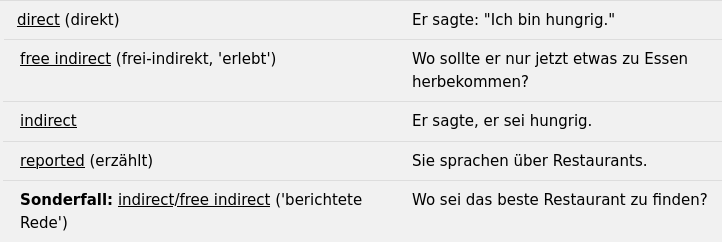

The speech type is added in form of a dictionary `{speech_type : score}` to all tokens. It ranges between 0 and 1 (it is the probability that the token belongs to that speech type).

In [25]:
# Create pipeline object
nlp = monapipe.model.load(disable=['ner'])
# Add components
nlp.add_pipe("dependency_clausizer")
nlp.add_pipe("quotation_marks_speech_tagger")
print(nlp.pipe_names)

['tok2vec', 'tagger', 'morphologizer', 'trainable_lemmatizer', 'parser', 'dependency_clausizer', 'quotation_marks_speech_tagger']


In [26]:
text_goethe_wahlverwandtschaften = aggregator.text("textgrid:11hnp.0").text
doc_goethe_wahlverwandtschaften = nlp(text_goethe_wahlverwandtschaften[24399:33069])

In [27]:
# Text snippet to work with in the following:
print(doc_goethe_wahlverwandtschaften[704:928])

Diejenigen, die auf die Namensbedeutungen abergläubisch sind, behaupten, der Name Mittler habe ihn genötigt, diese seltsamste aller Bestimmungen zu ergreifen.
Der Nachtisch war aufgetragen, als der Gast seine Wirte ernstlich vermahnte, nicht weiter mit ihren Entdeckungen zurückzuhalten, weil er gleich nach dem Kaffee fort müsse. Die beiden Eheleute machten umständlich ihre Bekenntnisse; aber kaum hatte er den Sinn der Sache vernommen, als er verdrießlich vom Tische auffuhr, ans Fenster sprang und sein Pferd zu satteln befahl.
»Entweder ihr kennt mich nicht,« rief er aus, »ihr versteht mich nicht, oder ihr seid sehr boshaft. Ist denn hier ein Streit? Ist denn hier eine Hülfe nötig? Glaubt ihr, daß ich in der Welt bin, um Rat zu geben? Das ist das dümmste Handwerk, das einer treiben kann. Rate sich jeder selbst und tue, was er nicht lassen kann. Gerät es gut, so freue er sich seiner Weisheit und seines Glücks; läufts übel ab, dann bin ich bei der Hand. Wer ein Übel los sein will, der wei

In [28]:
# Speech tagger output for clauses (clause roots) of text snippet above:
for i, clause in enumerate(doc_goethe_wahlverwandtschaften._.clauses[99:134]):
    print(i, clause, clause.root._.speech)

0 behaupten {}
1 der Name Mittler habe ihn genötigt {}
2 Der Nachtisch war aufgetragen {}
3 als der Gast seine Wirte ernstlich vermahnte {}
4 nicht weiter mit ihren Entdeckungen zurückzuhalten {}
5 weil er gleich nach dem Kaffee fort müsse {}
6 Die beiden Eheleute machten umständlich ihre Bekenntnisse {}
7 aber kaum hatte er den Sinn der Sache vernommen {}
8 als er verdrießlich vom Tische auffuhr {}
9 ans Fenster sprang {}
10 und sein Pferd zu satteln befahl {}
11 Entweder ihr kennt mich nicht {'direct': 1.0}
12 rief er aus {}
13 ihr versteht mich nicht {'direct': 1.0}
14 oder ihr seid sehr boshaft {'direct': 1.0}
15 Ist denn hier ein Streit {'direct': 1.0}
16 Ist denn hier eine Hülfe nötig {'direct': 1.0}
17 Glaubt ihr {'direct': 1.0}
18 daß ich in der Welt bin {'direct': 1.0}
19 um Rat zu geben {'direct': 1.0}
20 Das ist das dümmste Handwerk {'direct': 1.0}
21 das einer treiben kann {'direct': 1.0}
22 Rate sich jeder selbst {'direct': 1.0}
23 und tue {'direct': 1.0}
24 was er nicht l

#### Task
In the following cells, a new pipeline is created that includes the neural speech tagger with the additional labels (`freeIndirect`, `direct`, `reported`). Pipe the same text snippet and compare the output of the rule-based speech tagger above with the neural speech-tagger. Pay attention to the labels that are not present in the rule-based tagger.

In [3]:
# Create pipeline object
nlp = monapipe.model.load(disable=['ner'])
# Add components
nlp.add_pipe("dependency_clausizer")
nlp.add_pipe("flair_speech_tagger")

In [4]:
text_goethe_wahlverwandtschaften = aggregator.text("textgrid:11hnp.0").text
doc_goethe_wahlverwandtschaften = nlp(text_goethe_wahlverwandtschaften[24399:33069])

In [5]:
# your code here






##### possible solution

Code
```
text_goethe_wahlverwandtschaften = aggregator.text("textgrid:11hnp.0").text
doc = nlp(text_goethe_wahlverwandtschaften[24399:33069])
for i, clause in enumerate(doc._.clauses[99:134]):
    print(i, clause, clause.root._.speech)
```

Observations

In the first part of the text, the neural tagger correctly regognises indirect speech:
```
0 Diejenigen, die auf die Namensbedeutungen abergläubisch sind, behaupten, der Name Mittler habe ihn genötigt, diese seltsamste aller Bestimmungen zu ergreifen {'indirect': 7.5311426124804175}
1 die auf die Namensbedeutungen abergläubisch {}
2 sind {}
3 behaupten {}
4 der Name Mittler habe ihn genötigt {'indirect': 6.516442565492913}
5 Der Nachtisch war aufgetragen {}
6 als der Gast seine Wirte ernstlich vermahnte {}
7 nicht weiter mit ihren Entdeckungen zurückzuhalten {'indirect': 6.1728297341784595}
8 weil er gleich nach dem Kaffee fort müsse {'indirect': 8.377012617584246}
```

The neural tagger identifies reported speech:
```
9 Die beiden Eheleute machten umständlich ihre Bekenntnisse {'reported': 7.294128802971696}
```

Furthermore, it identifies clauses with mixed proportions of speech:
```
19 Glaubt ihr {'direct': 2.9845665153452963}
20 daß ich in der Welt bin {'indirect': 6.384563263299, 'direct': 6.970067813120923}
21 um Rat zu geben {'indirect': 4.9464183341046315, 'direct': 4.973735076951577, 'reported': 4.292892000878954}
```

# Optional Tasks

When you are done with the notebook, you can try to solve the following tasks as further exercises.

1. Preparation.
    - a) Read in Fontane's *Der Stechlin*.
    - b) Build a spaCy pipeline.
    - c) Pipe the text through the pipeline.
2. Corpus statistics.
    - a) How much of the text is written in past tense? Determine the percentage of clauses.
    - b) How much of the text is direct speech? Determine the percentage of clauses or tokens.
    - c) How many of the named entities in the text contain the word "Stechlin"? Determine the percentage of named entities.

Read in Fontane's *Der Stechlin*:

In [6]:
text_fontane_stechlin = aggregator.text("textgrid:n143.0").text

Build a spaCy pipeline:

In [7]:
nlp = monapipe.model.load()
# add the components you need with the `add_pipe` method here

Use the following block to work on the exercise questions.

In [8]:
# your code here:




